This notebook implements class balancing before splitting the training data into subsets, training a random forest classifier on each split, evaluating model performance and saving the fitted models. For Lesotho this notebook is used twice in the workflow, first to train models to produce a reference/baseline land cover map using the unfiltered training data, second to train models to produce a land cover map for a target year (2021) using the filtered training data.

In [3]:
%matplotlib inline
import os
import datacube
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score,cohen_kappa_score,confusion_matrix,ConfusionMatrixDisplay,balanced_accuracy_score
from joblib import dump

# file paths and attributes
dict_map={1:'Urban',2:'Cropland',4:'Trees',6:'Water',7:'Wetland',9:'Shrubland',10:'Grassland',12:'Barren',14:'Irrigated_Agriculture'} # dictionary of class name corresponding to each class value
# training_data='Results/landcover_training_data_2021_GEE.txt' # unfiltered training data
training_data='Results/landcover_td2021_filtered.txt' # filtered training data
class_name = 'LC_Class_I' # class label in integer format

# define features used for training and prediction
measurements = ['blue','green','red','red_edge_1','red_edge_2', 'red_edge_3','nir_1','swir_1','swir_2','NDVI'] # band measurements and index
column_names=[class_name]
for measurement in measurements:
    for i in range(6):
        column_names.append(measurement+'_'+str(i))

# import training data
df_training_data= pd.read_csv(training_data,delimiter=' ') # read as pandas dataframe
df_training_data=df_training_data[column_names] # keep only useful attributes
print('training data:\n',df_training_data)

training data:
       LC_Class_I  blue_0  blue_1  blue_2  blue_3  blue_4  blue_5  green_0  \
0            1.0   530.0   526.0   772.0   876.0   640.0   602.0    862.0   
1            1.0   923.0   835.0   834.0   918.0  1020.0  1108.0   1185.0   
2            1.0   616.0   525.0   574.0   603.0   676.0   884.0    875.0   
3            1.0   885.0   652.0   821.0   988.0   957.0   836.0   1211.0   
4            1.0  1267.0  1093.0  1062.0  1128.0  1286.0  1395.0   1803.0   
...          ...     ...     ...     ...     ...     ...     ...      ...   
3132        14.0   346.0   382.0   476.0   575.0   729.0   474.0    720.0   
3133        14.0   380.0   375.0   400.0   742.0   838.0   584.0    790.0   
3134        14.0   429.0   358.0   446.0   563.0   684.0   424.0    839.0   
3135        14.0   453.0   354.0   349.0   389.0   418.0   501.0    691.0   
3136        14.0   462.0   306.0   317.0   300.0   386.0   429.0    698.0   

      green_1  green_2  ...  swir_2_2  swir_2_3  swir_2_4  

Text(0.5, 0, 'Land cover class')

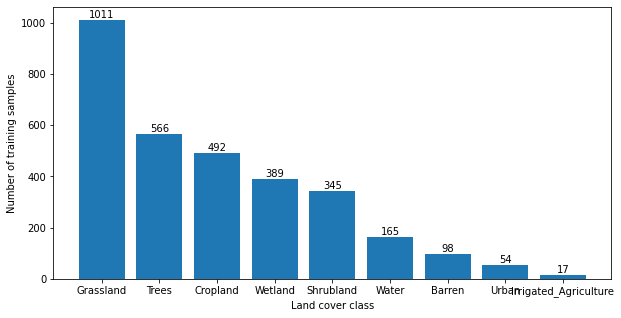

In [4]:
# plot the distribution of training samples by class
class_counts=df_training_data[class_name].value_counts()
class_indices=class_counts.index
class_legends=[dict_map[class_indices[i]] for i in range(len(class_indices))]
plt.figure(figsize=(10,5))
ax=plt.bar(class_legends,height=class_counts.to_numpy())
plt.bar_label(ax)
plt.gca().set_ylabel('Number of training samples')
plt.gca().set_xlabel('Land cover class')

/tmp/ipykernel_559/3500372816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_trees['random']=np.random.uniform(size=n_trees_train) # add a uniform distributed random number attribute
/tmp/ipykernel_559/3500372816.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_wetland['random']=np.random.uniform(size=n_wetland_train)


dimension of training data:  (2960, 67)
most importance features: 
 Index(['blue_5', 'swir_1_5', 'blue_1', 'red_edge_1_1', 'blue_2', 'red_0',
       'NDVI_5', 'NDVI_1', 'swir_2_1', 'green_5', 'NDVI_0', 'red_1',
       'swir_2_5', 'swir_2_4', 'red_2', 'swir_2_0', 'NDVI_3', 'green_1',
       'NDVI_2', 'NDVI_4'],
      dtype='object')
dimension of validation data:  (1391, 67)
Overall accuracy:  90.43853342918764 %
Balanced accuracy:  57.71023824914246 %
Kappa coefficient:  0.8666199964384511
Confusion matrix:

dimension of training data:  (2979, 67)


/tmp/ipykernel_559/3500372816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_trees['random']=np.random.uniform(size=n_trees_train) # add a uniform distributed random number attribute
/tmp/ipykernel_559/3500372816.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_wetland['random']=np.random.uniform(size=n_wetland_train)


most importance features: 
 Index(['red_5', 'red_edge_1_1', 'red_4', 'NDVI_1', 'red_0', 'NDVI_5',
       'swir_2_5', 'swir_2_3', 'swir_1_1', 'red_2', 'red_1', 'swir_1_0',
       'NDVI_0', 'swir_2_4', 'swir_2_2', 'swir_2_0', 'NDVI_3', 'green_1',
       'NDVI_2', 'NDVI_4'],
      dtype='object')
dimension of validation data:  (1390, 67)
Overall accuracy:  89.85611510791367 %
Balanced accuracy:  60.8205106988643 %
Kappa coefficient:  0.8593575757749721
Confusion matrix:

dimension of training data:  (2928, 67)


/tmp/ipykernel_559/3500372816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_trees['random']=np.random.uniform(size=n_trees_train) # add a uniform distributed random number attribute
/tmp/ipykernel_559/3500372816.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_wetland['random']=np.random.uniform(size=n_wetland_train)


most importance features: 
 Index(['swir_1_0', 'swir_2_3', 'green_2', 'NDVI_5', 'red_5', 'swir_2_5',
       'NDVI_0', 'blue_2', 'red_edge_1_1', 'red_2', 'NDVI_1', 'swir_1_2',
       'swir_2_2', 'red_0', 'red_1', 'NDVI_3', 'swir_2_0', 'swir_2_4',
       'NDVI_4', 'NDVI_2'],
      dtype='object')
dimension of validation data:  (1412, 67)
Overall accuracy:  89.58923512747874 %
Balanced accuracy:  59.0395218442363 %
Kappa coefficient:  0.8568539933352459
Confusion matrix:

dimension of training data:  (2994, 67)


/tmp/ipykernel_559/3500372816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_trees['random']=np.random.uniform(size=n_trees_train) # add a uniform distributed random number attribute
/tmp/ipykernel_559/3500372816.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_wetland['random']=np.random.uniform(size=n_wetland_train)


most importance features: 
 Index(['blue_4', 'blue_1', 'swir_1_1', 'swir_1_4', 'swir_2_3', 'red_2',
       'NDVI_5', 'swir_1_0', 'swir_2_5', 'blue_2', 'NDVI_0', 'NDVI_1',
       'green_1', 'red_edge_1_1', 'NDVI_3', 'swir_2_0', 'red_1', 'swir_2_4',
       'NDVI_2', 'NDVI_4'],
      dtype='object')
dimension of validation data:  (1360, 67)
Overall accuracy:  90.88235294117646 %
Balanced accuracy:  69.23783594382503 %
Kappa coefficient:  0.871841151119376
Confusion matrix:

dimension of training data:  (2937, 67)


/tmp/ipykernel_559/3500372816.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_trees['random']=np.random.uniform(size=n_trees_train) # add a uniform distributed random number attribute
/tmp/ipykernel_559/3500372816.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_split_wetland['random']=np.random.uniform(size=n_wetland_train)


most importance features: 
 Index(['NDVI_0', 'green_5', 'swir_2_3', 'red_2', 'swir_1_1', 'swir_1_0',
       'swir_2_1', 'blue_5', 'swir_2_5', 'swir_1_5', 'NDVI_1', 'blue_2',
       'green_1', 'red_1', 'NDVI_3', 'swir_2_4', 'red_edge_1_1', 'NDVI_4',
       'swir_2_0', 'NDVI_2'],
      dtype='object')
dimension of validation data:  (1404, 67)
Overall accuracy:  88.96011396011396 %
Balanced accuracy:  62.39594702993099 %
Kappa coefficient:  0.8472259955898984
Confusion matrix:

mean accuracy:  89.94527011317409 %


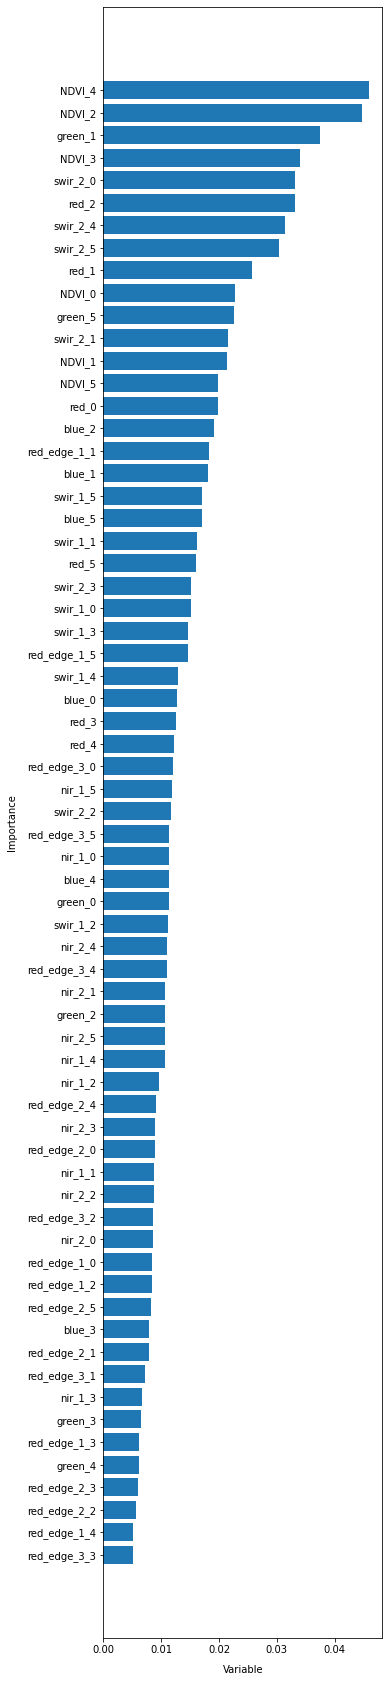

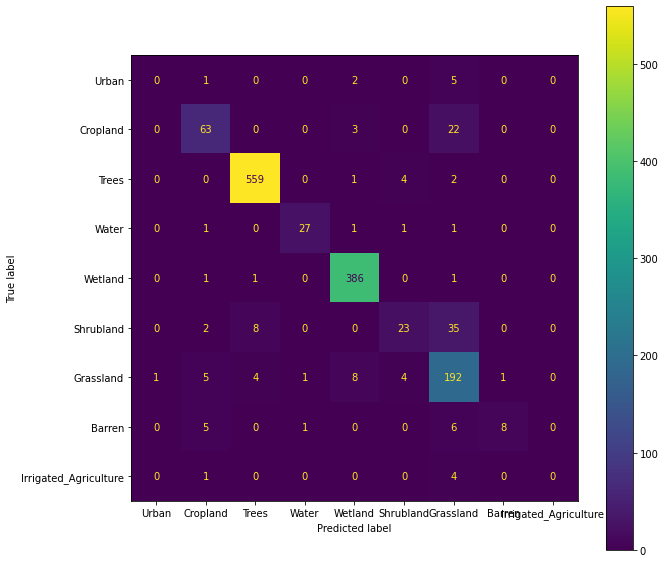

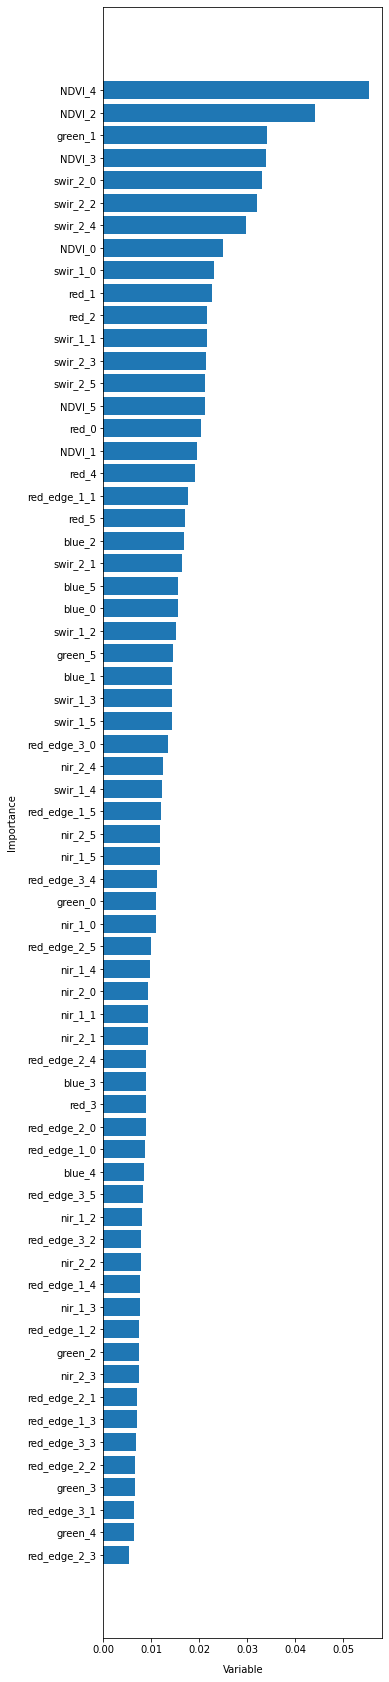

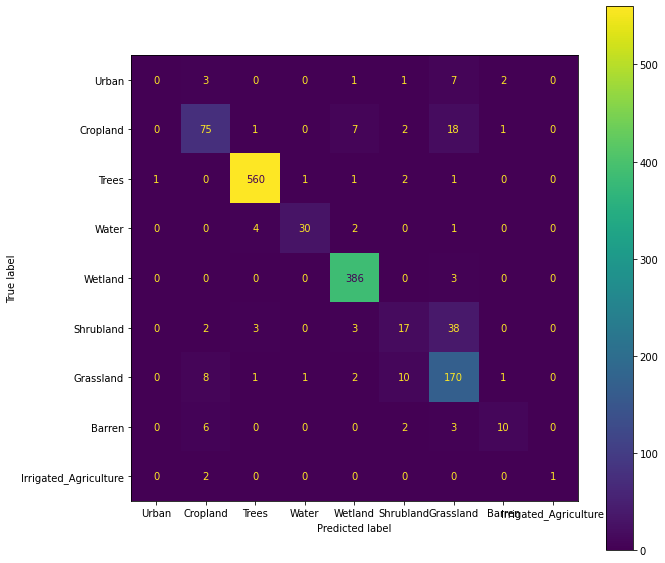

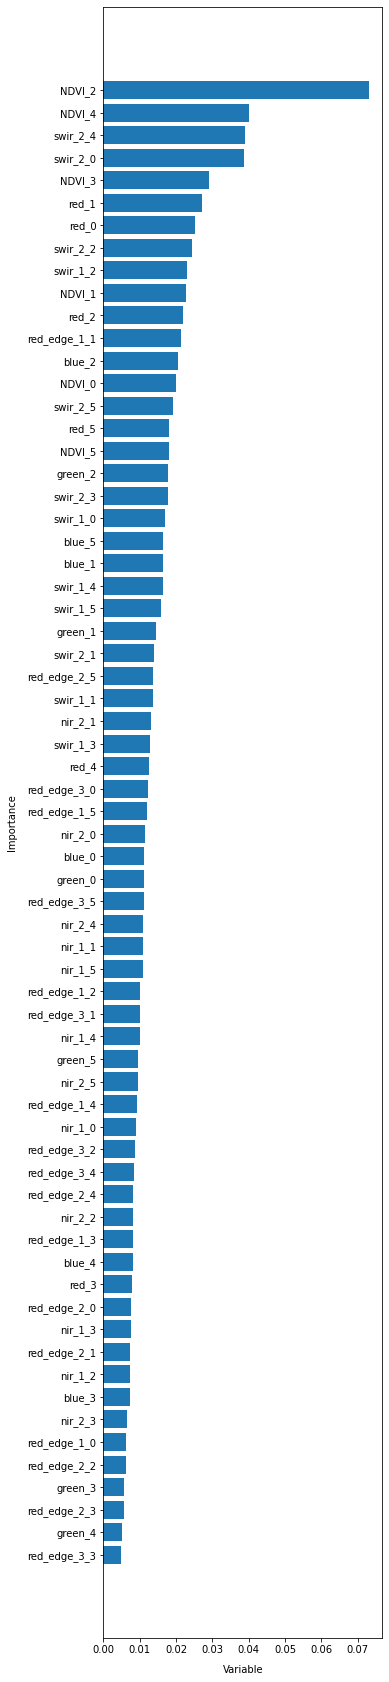

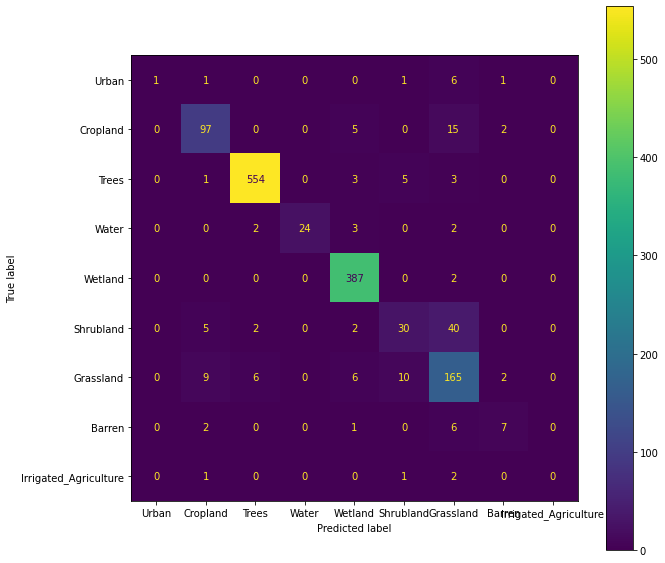

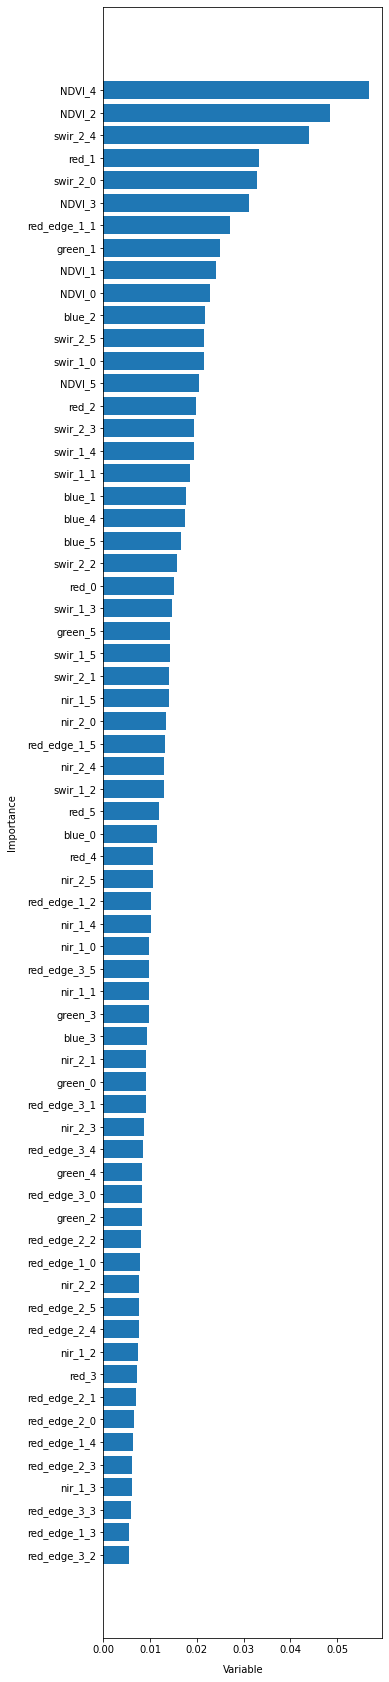

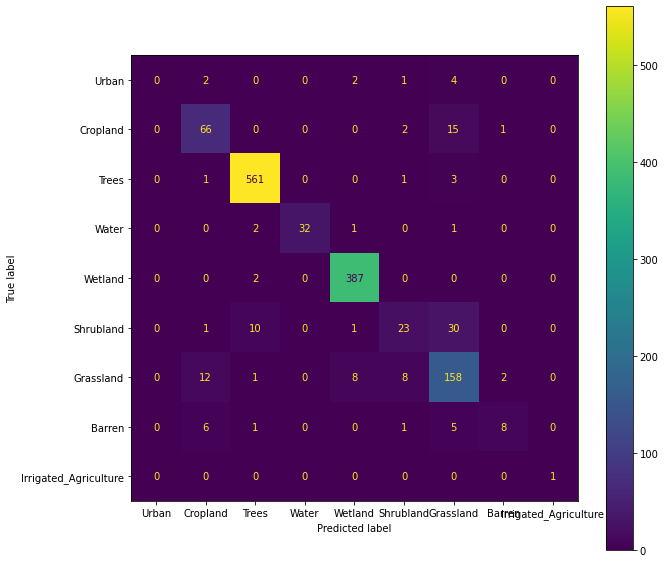

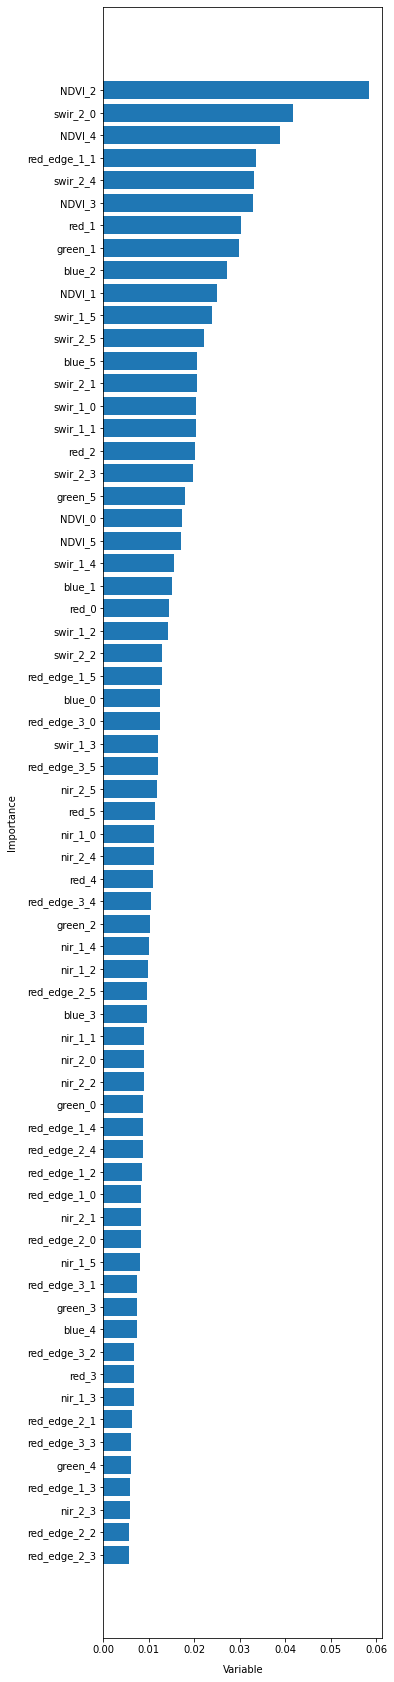

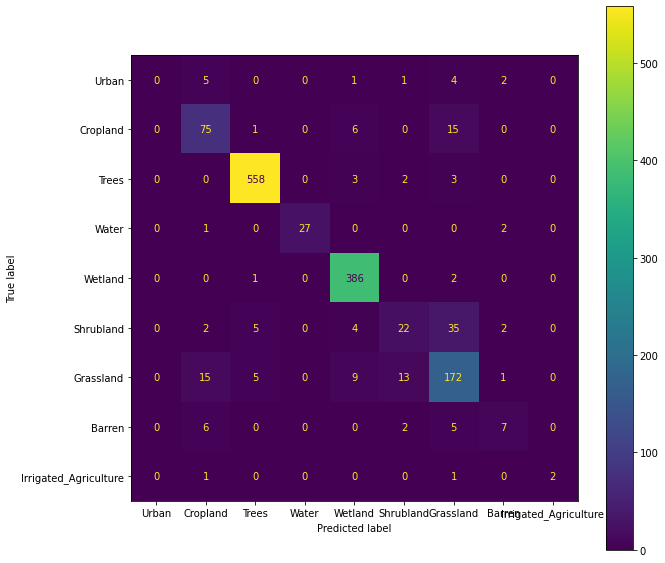

In [5]:
# split training data into five subsets, train and evaluate random forest classification model on each subset
rf_models=[] # initialise a list of fitted models
mean_acc=[] # initialise a list of overall accuracies
df_training_data['random']=np.random.uniform(size=df_training_data.shape[0]) # add a uniform distribution random number attribte which will be used for random splitting
for val in [0,0.2,0.4,0.6,0.8]:
    # split training data into training and validation subsets
    df_training_split=df_training_data[(df_training_data['random']<val)|(df_training_data['random']>=(val+0.2))] # extract training subset
    df_validation_split=df_training_data[(df_training_data['random']>=val)&(df_training_data['random']<(val+0.2))] # extract validation subset
    n_training_split=len(df_training_split) # trainig split size
    
    # reduce sample sizes of trees and wetland classes as they are over-represented
    df_train_split_trees=df_training_split[df_training_split[class_name]==4] # extract training samples by class attribute
    df_train_split_wetland=df_training_split[df_training_split[class_name]==7]
    
    n_trees_train=len(df_train_split_trees) # number of tree samples
    n_wetland_train=len(df_train_split_wetland) # number of wetland samples
    
    df_train_split_trees['random']=np.random.uniform(size=n_trees_train) # add a uniform distributed random number attribute
    df_train_split_wetland['random']=np.random.uniform(size=n_wetland_train)
    
    df_val_split_trees=df_train_split_trees.sort_values(by=['random'],ascending=False).iloc[0:np.min([n_trees_train,n_training_split-300])]
    df_val_split_wetland=df_train_split_wetland.sort_values(by=['random'],ascending=False).iloc[0:np.min([n_wetland_train,n_training_split-150])]
    
    df_train_split_trees=df_train_split_trees.sort_values(by=['random']).iloc[0:np.min([300,n_trees_train])] # limit tree samples to 300
    df_train_split_wetland=df_train_split_wetland.sort_values(by=['random']).iloc[0:np.min([150,n_wetland_train])] # limit wetland samples to 150
    
    df_training_split=pd.concat([df_training_split[(df_training_split[class_name]!=4)|(df_training_split[class_name]!=7)],
                                 df_train_split_trees,df_train_split_wetland]) # merge balanced samples back to training split
    df_validation_split=pd.concat([df_validation_split,df_val_split_trees,df_val_split_wetland]) # merge balanced samples back to validation split
    
    df_training_split=df_training_split[column_names] # keep only useful attributes
    df_validation_split=df_validation_split[column_names]
    
    # fit a random classifier
    model_input=df_training_split.to_numpy() # convert training subset from pandas dataframe to numpy array
    print('dimension of training data: ',model_input.shape)
    rf=RandomForestClassifier(n_estimators=50,max_samples=0.5,min_samples_leaf=1,bootstrap=True,n_jobs=-1)
    rf.fit(model_input[:,1:],model_input[:,0])
    
    # append the fitted model to the models list
    rf_models.append(rf)
    
    # plot and print feature importance
    order=np.argsort(rf.feature_importances_)
    plt.figure(figsize=(5,30))
    plt.barh(y=np.array(df_training_split.columns[1:])[order],width=rf.feature_importances_[order])
    plt.gca().set_ylabel('Importance', labelpad=10)
    plt.gca().set_xlabel('Variable', labelpad=10)
    feat_importance_indices=np.argsort(rf.feature_importances_)[-20:]
    print('most importance features: \n',df_training_split.columns[1:][feat_importance_indices])
    
    # evaluate using validation split
    model_test=df_validation_split.to_numpy() # convert validation subset from pandas dataframe to numpy array
    print('dimension of validation data: ',model_test.shape)
    predictions = rf.predict(model_test[:,1:])
    overall_acc=accuracy_score(model_test[:, 0],predictions)
    balanced_accuracy=balanced_accuracy_score(model_test[:, 0],predictions)
    kappa=cohen_kappa_score(predictions,model_test[:, 0])
    cm=confusion_matrix(model_test[:, 0], predictions)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[dict_map[rf.classes_[i]] for i in range(len(rf.classes_))])
    mean_acc.append(overall_acc*100)
    print('Overall accuracy: ',overall_acc*100,'%')
    print('Balanced accuracy: ',balanced_accuracy*100,'%')
    print('Kappa coefficient: ',kappa)
    print('Confusion matrix:\n')
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)
    
print('mean accuracy: ',np.mean(mean_acc),'%')
# save the models
# dump(rf_models, 'Results/RF_models_GEE_replicate.joblib') # model trained on the unfiltered training data
dump(rf_models, 'Results/RF_models_using_filtered_td_GEE_replicate.joblib') # model trained on the filtered training data